# Финальное задание

## Предметная область: Игра Dota 2

[Dota 2](https://ru.wikipedia.org/wiki/Dota_2) — многопользовательская компьютерная игра жанра [MOBA](https://ru.wikipedia.org/wiki/MOBA). Игроки играют между собой матчи. В каждом матче участвует две команды, 5 человек в каждой. Одна команда играет за светлую сторону (The Radiant), другая — за тёмную (The Dire). Цель каждой команды — уничтожить главное здание базы противника (трон).

Существуют [разные режимы игры](http://dota2.gamepedia.com/Game_modes/ru), мы будем рассматривать режим [Captain's Mode](http://dota2.gamepedia.com/Game_modes/ru#Captain.27s_Mode), в формате которого происходит большая часть киберспортивных мероприятий по Dota 2.

### Как проходит матч

#### 1. Игроки выбирают героев

Всего в игре чуть более 100 различных героев (персонажей). В начале игры, команды в определенном порядке выбирают героев себе и запрещают выбирать определенных героев противнику (баны). Каждый игрок будет управлять одним героем, в рамках одного матча не может быть несколько одинаковых героев.  Герои различаются между собой своими характеристиками и способностями. От комбинации выбранных героев во многом зависит успех команды.

![](http://imgur.com/XFr4HYE.jpg)

#### 2. Основная часть

Игроки могут получать золото и опыт за убийство чужих героев или прочих юнитов. Накопленный опыт влияет на уровень героя, который в свою очередь позволяет улучшать способности. За накопленное золото игроки покупают предметы, которые улучшают характеристики героев или дают им новые способности.

После смерти герой отправляется в "таверну" и возрождается только по прошествии некоторого времени, таким образом команда на некоторое время теряет игрока, однако игрок может досрочно выкупить героя из таверны за определенную сумму золота.

В течение игры команды развивают своих героев, обороняют свою часть поля и нападают на вражескую.

![](http://imgur.com/5b0SlQb.jpg)

#### 3. Конец игры

Игра заканчивается, когда одна из команд разрушет определенное число "башен" противника и уничтожает трон.

![](http://imgur.com/Du79Kzf.jpg)

## Задача: предсказание победы по данным о первых 5 минутах игры

По первым 5 минутам игры предсказать, какая из команд победит: Radiant или Dire?

    Вам нужно построить модель, которая по данным о первых пяти минутах матча будет предсказывать его исход — то есть
    определять команду-победителя.

Чтобы выполнить это задание, вам необходимо провести ряд исследований, сравнить несколько алгоритмов машинного обучения и проверить эффект от ряда манипуляций с признаками. Также, если вам понравится работать с этими данными, вы можете принять участие в [соревновании на Kaggle](https://www.kaggle.com/t/661af3410a5e481a944a31da8ab5d7f6) и сравнить свои навыки с другими участниками курса!

## Набор данных

Набор данных с матчами записан в файле `matches.jsonlines.bz2`.
В каталоге `dictionaries` приведены расшифровки идентификаторов, которые присутствуют в записях матчей.

#### Чтение информации о матчах

Информация о матчах записана в сжатом текстовом файле `matches.jsonlines.bz2`, каждая строчка которого содержит объект в формате [JSON](https://ru.wikipedia.org/wiki/JSON). Запись в формате JSON преобразуется в python-объект при помощи стандартного модуля `json`. Пример чтения матчей:

```python
import json
import bz2

with bz2.BZ2File('./matches.jsonlines.bz2') as matches_file:
    for line in matches_file:
        match = json.loads(line)
        
        # Обработка матча
        break
```
#### Описание полей в записи матча

```python
{
    "match_id": 247,            # идентификатор матча
    "start_time": 1430514316,   # дата/время начала матча, unixtime
    "lobby_type": 0,            # тип комнаты, в которой собираются игроки 
                                #   (расшифровка в dictionaries/lobbies.csv)
 
    # стадия выбора героев
    "picks_bans": [
        {
            "order": 0,       # порядковый номер действия
            "is_pick": false, # true если команда выбирает героя, false — если банит
            "team": 1,        # команда, совершающая действие (0 — Radiant, 1 — Dire)
            "hero_id": 95     # герой, связанный с действием 
                              #    (расшифровка в dictionaries/heroes.csv)
        }, 
        ...
    ],

    # информация про каждого игрока, список ровно из 10 элементов
    # игроки с индексами от 0 до 4 — из команды Radiant, от 5 до 9 — Dire
    "players": [ 
        { 
        
            # герой игрока (расшифровка в dictionaries/heroes.csv)
            "hero_id": 67,  

            # временные ряды (отсчеты указаны в поле "times")
            "xp_t": [0, 13, 115, 177, 335, ...],   # опыт
            "gold_t": [0, 99, 243, 343, 499, ...], # золото + стоимость всех купленных вещей (net worth)
            "lh_t": [0, 0, 2, 2, 2, ...],          # количество убитых юнитов (не героев) противника

            # список событий: улучшение способностей героя
            "ability_upgrades": [
                {
                    "time": 51,      # игровое время
                    "level": 1,      # уровень игрока, на котором произошло улучшение
                    "ability": 5334  # способность, которая была улучшена 
                                     # (расшифровка в dictionaries/abilities.csv)
                }, 
                ...
            ],

            # список событий: убийства
            "kills_log": [
                {
                    "time": 831,    # игровое время
                    "player": 7,    # индекс игрока, чей герой был убит 
                                    #   (не заполнено, если был убит не герой)
                    "unit": "npc_dota_hero_viper" # тип убитого юнита
                }, 
                ...
            ],

            # список событий: покупка предметов
            "purchase_log": [
                {
                    "time": -73,     # игровое время
                                     #   точка отсчета игрового времени (ноль) начинается через
                                     #   несколько минут после фактического начала матча, поэтому
                                     #   время некоторых событий может быть отрицательным
                    "item_id": 44    # купленный предмер (расшифровка в dictionaries/items.csv)
                }, 
                ...
            ]

            # список событий: выкуп героя из таверны
            "buyback_log": [
                {"time": 2507},
                ...
            ],

            # список событий: установка героем "наблюдателей", позволяющих команде 
            # следить за чатью игрового поля на некотором расстоянии от точки установки
            "obs_log": [
                {
                    "time": 1711,    # игровое время установки
                    "xy": [111, 130] # координаты игрового поля
                }, 
                ...
            ],
            "sen_log": [], # аналогично полю obs_log, другой тип "наблюдателя"

        },
        ...
    ],
    
    # отсчеты игрового времени, в которые вычисляются значения временных рядов
    "times": [0, 60, 120, 180, ...],

    # ключевые события игры
    "objectives": [
        {
            "time": 198,           # время события
            "type": "firstblood",  # тип события
            "player1": 6,          # параметры события, могут содержать
            "player2": 1           #   индексы игроков (player), 
                                   #   номер команды (team, 0 — Radiant, 1 — Dire)
        }, 
        {
            "time": 765, 
            "type": "tower_kill", 
            "player": 7, 
            "team": 1
        }, 
        ...
    ]
    
    # итог матча (отсутствует в тестовых матчах)
    "finish": {
        "duration": 2980,             # длительность в секундах
        "radiant_win": false,         # true, если победила команда Radiant
        "tower_status_radiant": 0,    # состояние башен у команд к концу игры
        "tower_status_dire": 1972,    #   (см. описание битовой маски)
        "barracks_status_dire": 63,   # состояние бараков у команд к концу игры
        "barracks_status_radiant": 0  #   (см. описание битовой маски)
    }
}
```

#### Описание полей состояния башен и бараков

Состояние башен к концу игры задается целым числом, закодировано в битах:

```
┌─┬─┬─┬─┬─────────────────────── Not used.
│ │ │ │ │ ┌───────────────────── Ancient Bottom
│ │ │ │ │ │ ┌─────────────────── Ancient Top
│ │ │ │ │ │ │ ┌───────────────── Bottom Tier 3
│ │ │ │ │ │ │ │ ┌─────────────── Bottom Tier 2
│ │ │ │ │ │ │ │ │ ┌───────────── Bottom Tier 1
│ │ │ │ │ │ │ │ │ │ ┌─────────── Middle Tier 3
│ │ │ │ │ │ │ │ │ │ │ ┌───────── Middle Tier 2
│ │ │ │ │ │ │ │ │ │ │ │ ┌─────── Middle Tier 1
│ │ │ │ │ │ │ │ │ │ │ │ │ ┌───── Top Tier 3
│ │ │ │ │ │ │ │ │ │ │ │ │ │ ┌─── Top Tier 2
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ ┌─ Top Tier 1
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
```

Состояние бараков к концу игры закодировано в битах целого числа:

```
┌─┬───────────── Not used.
│ │ ┌─────────── Bottom Ranged
│ │ │ ┌───────── Bottom Melee
│ │ │ │ ┌─────── Middle Ranged
│ │ │ │ │ ┌───── Middle Melee
│ │ │ │ │ │ ┌─── Top Ranged
│ │ │ │ │ │ │ ┌─ Top Melee
│ │ │ │ │ │ │ │
0 0 0 0 0 0 0 0
```

## Извлечение признаков

Скрипт extract_features.py производит извлечение признаков из известной информации о матче за первые 5 игровых минут, составляет из них таблицу. Таблица поможет вам быстрее сформировать матрицу объект-признак, вектор ответов и начать применять методы машинного обучения для решения поставленной задачи.

Признаки, представленные в таблице `features.csv`, по мнению экспертов в предметной области являются наиболее важными для решения задачи предсказания победы команды. Тем не менее, не обязательно использовать эти признаки в исходном виде для применения методов машинного обучения — вы можете сделать новые признаки из имеющихся. Более того, признаки в файле `features.csv` содержат не всю информацию, известную про матч за первые 5 игровых минут. Вы можете использовать скрипт `extract_features.py` как пример и добавлять свои признаки для улучшения качества предсказания.

#### Пример чтения файла с признаками

In [1]:
import pandas
features = pandas.read_csv('features.csv', index_col='match_id')

features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

## Метрика качества

В качестве метрики качества мы будем использовать площадь под ROC-кривой (AUC-ROC). Обратите внимание, что AUC-ROC — это метрика качества для алгоритма, выдающего оценки принадлежности первому классу. Оба алгоритма, которые будут использоваться в проекте — градиентный бустинг, и логистическая регрессия — умеют выдавать такие оценки. Для этого нужно получать предсказания с помощью функции predict_proba. Она возвращает два столбца: первый содержит оценки принадлежности нулевому классу, второй — первому классу. Вам нужны значения из второго столбца:
```python
pred = clf.predict_proba(X_test)[:, 1]
```

    Следует понимать, что конкретные показатели метрик качества могут отличаться в зависимости от конкретных разбиений 
    выборки, значений параметров и версий библиотек. Ответы следует проверять на адекватность — в правильную ли сторону
    изменяется показатель качества при том или ином изменении модели или выборки, корректные ли выводы делаются из
    соответствующих результатов.

## Руководство по решению

Вам необходимо провести описанные ниже два этапа исследования, написать по результатам каждого этапа небольшой отчет (ниже указаны вопросы, ответы на которые должны содержаться в отчете), и предоставить для ревью данный отчет и код, с помощью которого вы выполнили задание.

**Обратите внимание:** высокое качество работы на кросс-валидации (близкое к 100%) — это в первую очередь повод задуматься о том, правильно ли вы обучаете модель. Возможно, вы заглядываете в будущее или настраиваетесь на неправильном наборе признаков.

    Не забывайте, что в выборке есть признаки, которые "заглядывают в будущее" — они помечены в описании данных как
    отсутствующие в тестовой выборке. Их прямое использование в модели приведет к переобучению, поэтому не забудьте
    исключить их из выборки

### Подход 1: градиентный бустинг "в лоб"
Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

1. Считайте таблицу с признаками из файла `features.csv` с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
2. Проверьте выборку на наличие пропусков с помощью функции `count()`, которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.
3. Замените пропуски на нули с помощью функции `fillna()`. На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.
3. Какой столбец содержит целевую переменную? Запишите его название.
4. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (`KFold`), не забудьте перемешать при этом выборку `(shuffle=True)`, поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (`GradientBoostingClassifier`) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра `n_estimators`, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
2. Как называется столбец, содержащий целевую переменную?
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?


##### Рекомендации и советы

- Если все работает очень медлено:
   - Используйте для обучения и кросс-валидации не всю выборку, а некоторое ее подмножество — например, половину объектов. Подмножество лучше всего брать случайным, а не формировать его из первых m объектов.
   - Попробуйте упростить модель — например, уменьшить глубину деревьев в градиентом бустинге (max_depth).
   
##### Измерение времени работы кода
```python
import time
import datetime

start_time = datetime.datetime.now()

time.sleep(3) # вместо этой строчки разместить замеряемый код

print 'Time elapsed:', datetime.datetime.now() - start_time
```

#### Шаг 1:

Считайте таблицу с признаками из файла `features.csv` с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.metrics import roc_auc_score
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import time
import datetime

In [3]:
df_train = pandas.read_csv('features.csv', index_col='match_id')

print('Shape of df_train:', df_train.shape)
df_train.head()

Shape of df_train: (97230, 108)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [4]:
cols = ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire']

X_train = df_train.drop(cols, axis=1)
y_train = df_train['radiant_win']

print('Shape of df_train after dropping leaking features:', X_train.shape)

Shape of df_train after dropping leaking features: (97230, 102)


#### Шаг 2:

Проверьте выборку на наличие пропусков с помощью функции `count()`, которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [5]:
s = X_train.count()
s.loc[s < X_train.shape[0]]

first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

**Обоснование (применимо ко всем признакам)**: за первые 5 минут не произошло события описываемого признаком. 

#### Шаг 3:

Замените пропуски на нули с помощью функции `fillna()`. На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [6]:
X_train.fillna(0, inplace=True)

#### Шаг 4:

Какой столбец содержит целевую переменную? Запишите его название.

#### Шаг 5:

Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (`KFold`), не забудьте перемешать при этом выборку (`shuffle=True`), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (`GradientBoostingClassifier`) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра `n_estimators`, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [7]:
scores = {}
cv = KFold(n_splits=5, shuffle=True)

for n in [10, 20, 30]:
    start_time = datetime.datetime.now()
    clf = GradientBoostingClassifier(n_estimators=n)
    scores[n] = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
    print('\nFor {} trees ROC-AUC score:'.format(n), scores[n])
    print('Time elapsed:', datetime.datetime.now() - start_time)


For 10 trees ROC-AUC score: 0.6645034532371432
Time elapsed: 0:00:28.175611

For 20 trees ROC-AUC score: 0.6823239684665252
Time elapsed: 0:00:46.528662

For 30 trees ROC-AUC score: 0.6898295576594543
Time elapsed: 0:01:10.787048


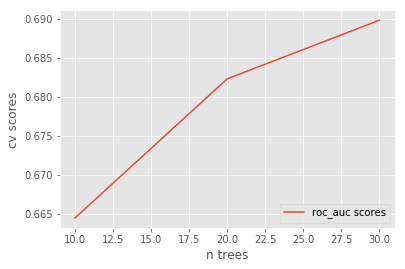

In [8]:
plt.plot(scores.keys(), scores.values(), label='roc_auc scores')
plt.xlabel('n trees')
plt.ylabel('cv scores')
plt.legend(loc='lower right')
plt.show()

**Ответ:** 

* Время настройки классификатора растёт с увеличением числа деревьев
* При этом с ростом числа деревьев растёт качество на кросс-валидации, соответственно, скорее всего, оптимум не достигнут и качество продолжит расти при дальнейшем увеличении числа деревьев. 

### Отчёт:

**1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?**

    first_blood_time               77677
    first_blood_team               77677
    first_blood_player1            77677
    first_blood_player2            53243
    radiant_bottle_time            81539
    radiant_courier_time           96538
    radiant_flying_courier_time    69751
    radiant_first_ward_time        95394
    dire_bottle_time               81087
    dire_courier_time              96554
    dire_flying_courier_time       71132
    dire_first_ward_time           95404

**Ответ:** за первые 5 минут не произошло события описываемого признаком.

**2. Как называется столбец, содержащий целевую переменную?**

    'radiant_win'

**3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.**
    
    For 30 trees ROC-AUC score: 0.6898295576594543
    Time elapsed: 0:01:10.787048
    
**4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?**

   * Исходя из графика $-$ имеет
   * Избавиться от шумовых признаков, уменьшить размер подвыборки, воспользоваться методом главных компонент (PCA), либо другими методами машинного обучения для уменьшения размерности.

### Подход 2: логистическая регрессия

Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

**Важно:** не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться `sklearn.preprocessing.StandartScaler`.

1. Оцените качество логистической регрессии (`sklearn.linear_model.LogisticRegression` с `L2`-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: `lobby_type` и `r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero`. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?
3. На предыдущем шаге мы исключили из выборки признаки `rM_hero` и `dM_hero`, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция `unique` или `value_counts`).
4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду `Radiant`; минус единице, если i-й герой играл за команду `Dire`. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.
5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?
6. Постройте предсказания вероятностей победы команды `Radiant` для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения `AUC-ROC` на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
3. Сколько различных идентификаторов героев существует в данной игре?
4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?


##### Код для формирования "мешка слов" по героям
```python
# N — количество различных героев в выборке
X_pick = np.zeros((data.shape[0], N))

for i, match_id in enumerate(data.index):
    for p in xrange(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
```

#### Шаг 1:

Оцените качество логистической регрессии (`sklearn.linear_model.LogisticRegression` с `L2`-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (`C`). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [10]:
def log_reg(X, y):
    
    scores = {}

    for C in np.power(10.0, np.arange(-3, 3)):
        start_time = datetime.datetime.now()

        scaler = StandardScaler()
        clf = LogisticRegression(C = C)
        pipeline = Pipeline([('transformer', scaler), ('estimator', clf)]) 

        scores[C] = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
        print('\nFor C = {} ROC-AUC score:'.format(C), scores[C])
        print('Time elapsed:', datetime.datetime.now() - start_time)

    best_score, best_c = max(scores.values()), max(scores, key=scores.get)
    print('\nBest score:', best_score , 'with C = {}'.format(best_c))
    
    return best_score, best_c

In [11]:
best_score, best_c = log_reg(X_train, y_train)


For C = 0.001 ROC-AUC score: 0.7162248485293705
Time elapsed: 0:00:08.712498

For C = 0.01 ROC-AUC score: 0.7167122133359051
Time elapsed: 0:00:12.399709

For C = 0.1 ROC-AUC score: 0.716366988200287
Time elapsed: 0:00:12.903738

For C = 1.0 ROC-AUC score: 0.7165095202364735
Time elapsed: 0:00:12.683726

For C = 10.0 ROC-AUC score: 0.7165066946342797
Time elapsed: 0:00:12.409710

For C = 100.0 ROC-AUC score: 0.7164001505007075
Time elapsed: 0:00:12.357706

Best score: 0.7167122133359051 with C = 0.01


#### Шаг 2:

Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: `lobby_type` и `r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero`. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [12]:
cols = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

X_train_wcat = X_train.drop(cols, axis=1)

print('Shape of df_train after dropping categorical features:', X_train_wcat.shape)
X_train_wcat.head()

Shape of df_train after dropping categorical features: (97230, 91)


,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,5,2098,1489,20,0,0,7,3,842,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,4,1188,1033,9,0,1,12,4,1596,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,4,1319,1270,22,0,0,12,3,1314,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,4,1779,1056,14,0,0,5,2,539,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,4,1431,1090,8,1,0,8,2,629,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


In [13]:
best_score, best_c = log_reg(X_train_wcat, y_train)


For C = 0.001 ROC-AUC score: 0.7163183404798956
Time elapsed: 0:00:08.453484

For C = 0.01 ROC-AUC score: 0.7163618258820328
Time elapsed: 0:00:10.483600

For C = 0.1 ROC-AUC score: 0.7164912463291214
Time elapsed: 0:00:10.486599

For C = 1.0 ROC-AUC score: 0.7163927242692321
Time elapsed: 0:00:11.083634

For C = 10.0 ROC-AUC score: 0.7165622726720877
Time elapsed: 0:00:11.500658

For C = 100.0 ROC-AUC score: 0.7165311825823906
Time elapsed: 0:00:11.657667

Best score: 0.7165622726720877 with C = 10.0


#### Шаг 3:

На предыдущем шаге мы исключили из выборки признаки `rM_hero` и `dM_hero`, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция `unique` или `value_counts`).

In [14]:
N = max(X_train['r1_hero'].unique())
N

112

#### Шаг 4: 

Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду `Radiant`; минус единице, если i-й герой играл за команду `Dire`. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [15]:
def encoding(X, N):
    # N — количество различных героев в выборке
    X_pick = np.zeros((X.shape[0], N))

    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_pick[i, X.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, X.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
            
    return X_pick

In [16]:
X_pick = encoding(X_train, N)

In [17]:
X_train_cat = np.concatenate((X_train_wcat, X_pick), axis = 1)
X_train_cat.shape

(97230, 203)

#### Шаг 5:

Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [18]:
best_score, best_c = log_reg(X_train_cat, y_train)


For C = 0.001 ROC-AUC score: 0.7514942892571972
Time elapsed: 0:00:16.564947

For C = 0.01 ROC-AUC score: 0.7517674535068141
Time elapsed: 0:00:20.975200

For C = 0.1 ROC-AUC score: 0.7517698633283052
Time elapsed: 0:00:23.512345

For C = 1.0 ROC-AUC score: 0.7516593407332065
Time elapsed: 0:00:21.960256

For C = 10.0 ROC-AUC score: 0.7519468481057208
Time elapsed: 0:00:21.461228

For C = 100.0 ROC-AUC score: 0.751816290738691
Time elapsed: 0:00:22.287274

Best score: 0.7519468481057208 with C = 10.0


#### Шаг 6: 

Постройте предсказания вероятностей победы команды `Radiant` для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения `AUC-ROC` на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [19]:
df_test = pd.read_csv('features_test.csv', index_col='match_id')
df_test.fillna(0, inplace=True)

X_test_wcat = df_test.drop(cols, axis=1)
X_pick = encoding(df_test, N)

X_test_cat = np.concatenate((X_test_wcat, X_pick), axis = 1)

X_train = StandardScaler().fit_transform(X_train_cat)
X_test = StandardScaler().fit_transform(X_test_cat)

clf = LogisticRegression(C=best_c)
clf = clf.fit(X_train, y_train)

pred = clf.predict_proba(X_test)[:, 1]
pred

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.82499485, 0.75855233, 0.18699089, ..., 0.23114573, 0.63195823,
       0.42598017])

### Отчёт:

**1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?**

* Best score: 0.7167122133359051 with C = 0.01  
* Качество на кросс-валидации лучше, у градиентного бустинга лучший результат для 30 деревьев: 0.6898295576594543
* ...
* Да, быстрее

**2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества) Чем вы можете объяснить это изменение?**

* Best score: 0.7165622726720877 with C = 10.0 $-$ незначительно ухудшилось, практически не изменилось 
* Необработанные категориальные признаки являются шумовыми признаками

**4. Сколько различных идентификаторов героев существует в данной игре?**
     
     112
     
**5. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?**

* Best score: 0.7519468481057208 with C = 10.0
* Да, улучшилось
* Моделью учтены обработанные категориальные признаки

**6. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?**

In [20]:
print('Min prediction:', min(pred))
print('Max prediction:', max(pred))

Min prediction: 0.00868998577636151
Max prediction: 0.9964872672836553


## Проверка финальной модели

После того как вы провели все эксперименты и выбрали лучшую модель, можете проверить ее качество на тестовых матчах. Выборка тестовых матчей собрана в файле `matches_test.jsonlines.bz2`. В отличие от основного набора матчей, в тестовых матчах есть только та информация, которая известна на момент первых 5 игровых минут, результат матча — неизвестен. Таблица признаков для тестовых матчей — `features_test.csv`.

Для всех матчей из тестового набора предскажите вероятность победы Radiant, запишите предсказания в CSV файл с колонками `match_id` (идентификатор матча) и `radiant_win` — предсказанная вероятность. Файл с предсказаниями должен выглядеть примерно следующим образом:

```
match_id,radiant_win
1,0.51997370502
4,0.51997370502
15,0.51997370502
...
```

Отправьте решение на Kaggle в соревнование: Dota 2: Win Probability Prediction.

Ссылка на соревнование: [Dota 2: Win Probability Prediction](https://kaggle.com/join/coursera_ml_dota2_contest)

### Что еще попробовать?

Разумеется, можно попробовать еще очень много разных идей, которые помогут вам получить еще более высокий результат на kaggle. Вот лишь несколько возможных вариантов:
1. Про каждого из игроков есть достаточно много показателей: максимальный опыт, число смертей и т.д. (см. список выше). Можно попробовать просуммировать или усредних их, получив агрегированные показатели для всей команды.
2. В сырых данных (файл matches.jsonlines.bz2) содержится очень много информации, которую мы пока не использовали. Вы можете, например, составить "мешки слов" для покупок различных предметов (то есть кодировать информацию о том, сколько раз каждая команда покупала тот или иной предмет). Обратите внимание, что при этом вы можете получить слишком большое количество признаков, для которых может иметь смысл сделать понижение размерности с помощью метода главных компонент.
3. Можно сформировать признаки про изменения способностей героев в течение матча (ability_upgrades).
4. В этом задании используются только градиентный бустинг и логистическая регрессия — но ведь мы изучали и другие модели! Можно попробовать метод k ближайших соседей, SVM, случайный лес и так далее.

## Про задачу и финальное задание

#### Почему именно такая задача?

- Публикация реальных данных из индустриальных задач — очень смелый шаг для компании. Мало кто (даже Яндекс) может на такое пойти. Гораздо проще (а порой и интереснее) воспользоваться данными из открытых источников.
- Публичные датасеты из интернета для решения реальных бизнес-задач мало пригодны, собственно поэтому они и лежат в открытом доступе.
- Мы предпочли сделать игрушечную задачу на реальных данных, вместо реальной задачи на игрушечных данных.
- Задача прогнозирования победы — игрушечная, но вот лишь небольшой перечень реальных задач, на которые она похожа:
    - предсказания вероятности покупки услуги клиентом банка
    - предсказание вероятности оттока клиента к другому поставщику услуг
    - ... (подумайте над другими примерами)

#### Задание слишком простое. Что еще можно сделать?

Ответить на вопрос: какое минимальное число минут матча необходимо знать, для того чтобы в 80% матчей верно угадывать победившую сторону? А с точностью 90%? Дайте свой ответ на этот вопрос и докажите что такой точности действительно можно достичь, построив модель и качественно провалидировав ее. Насколько матчи в игре Dota 2 предсказуемы?

Напишите об этом статью, расскажите всем, и приходите к нам на собеседование.

#### Где взяли данные?

Набор данных был сделан на основе выгрузки [YASP 3.5 Million Data Dump](http://academictorrents.com/details/5c5deeb6cfe1c944044367d2e7465fd8bd2f4acf) реплеев матчей Dota 2 с сайта [yasp.co](http://yasp.co/). За выгрузку огромное спасибо Albert Cui and Howard Chung and Nicholas Hanson-Holtry. Лицензия на выгрузку: CC BY-SA 4.0.

#### Как сформировали выборку?

Оригинальная выгрузка матчей была очищена, в предложенном наборе присутствуют матчи:
  - сыгранные с 2015-05-01 до 2015-12-17
  - длительностью не менее 15 минут
  - убраны матчи с неполной информацией (например: отсутвует информация про игроков)

Из всего датасета 15% случайных записей были выделены в тестовое множество.

Для того чтобы размотивировать участников соревнования на Kaggle занимать высокие места читерскими методами (например, скачав оригинальный набор данных и подсмотрев ответы на тестовом множестве матчей), мы произвели минимальную обфускацию данных, т.е. немного запутали датасет:
   - поменяли идентификаторы матчей
   - время начала каждого матча сдвинули на значение случайной величины, нормально распределенной со стандартным отклонением в 1 сутки